In [1]:
from python_files.import_libs import *
from python_files.predict import *

%matplotlib inline

In [2]:
# Load the train data
sales_data = pd.read_csv('data/train.csv')

In [3]:
# Replace all datas for numeric datas
le = preprocessing.LabelEncoder()

sales_data['store'] = le.fit_transform(sales_data['store'])

sales_data.info()
sales_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int32 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int32(1), int64(2), object(1)
memory usage: 24.4+ MB


,date,store,item,sales
0,2015-01-01,0,1,13
1,2015-01-02,0,1,11
2,2015-01-03,0,1,14
3,2015-01-04,0,1,13
4,2015-01-05,0,1,10


In [4]:
# Sales per month
month_df = sales_data.copy()
month_df.date = month_df.date.apply(lambda x: str(x)[:-3])
month_df = month_df.groupby('date')['sales'].sum().reset_index()
month_df.date = pd.to_datetime(month_df.date,errors='coerce')
month_df.head()

,date,sales
0,2015-01-01,454904
1,2015-02-01,459417
2,2015-03-01,617382
3,2015-04-01,682274
4,2015-05-01,763242


In [5]:
# The duration of Dataset
sales_data.date = pd.to_datetime(sales_data.date,errors='coerce')
number_days = sales_data.date.max() - sales_data.date.min()
number_years = number_days.days / 365
print(number_days.days, 'days')
print(number_years, 'years')

1825 days
5.0 years


[Text(0.5, 0, 'Sales Per day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Distrobution of Sales Per Day')]

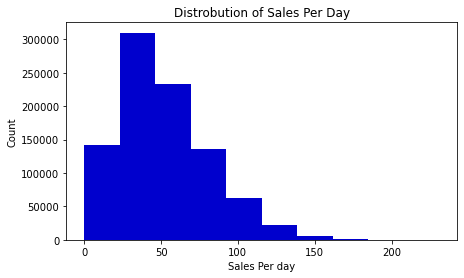

In [6]:
# Plot of sales per day
fig, ax = plt.subplots(figsize=(7,4))
plt.hist(sales_data.sales, color='mediumblue')
    
ax.set(xlabel = "Sales Per day",
        ylabel = "Count",
        title = "Distrobution of Sales Per Day")

C:\Users\mathe\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


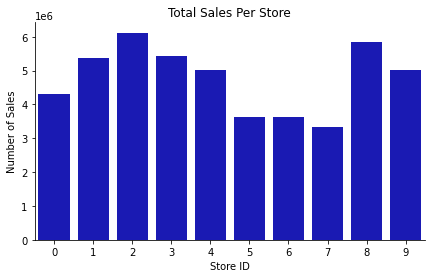

In [7]:
# Plot of sales per store
by_store = sales_data.groupby('store')['sales'].sum().reset_index()
    
fig, ax = plt.subplots(figsize=(7,4))
sns.barplot(by_store.store, by_store.sales, color='mediumblue')
    
ax.set(xlabel = "Store ID",
       ylabel = "Number of Sales",
       title = "Total Sales Per Store")
    
sns.despine()

In [8]:
# Average monthly sales overall
avg_month_sales = month_df.sales.mean()
print(f"Overall average monthly sales: ${avg_month_sales}")

Overall average monthly sales: $782041.1803278689


In [9]:
# Average monthly sales Last 12 months
avg_month_sales_12month = month_df.sales[-12:].mean()
print(f"Last 12 months average monthly sales: ${avg_month_sales_12month}")

Last 12 months average monthly sales: $844445.8333333334


In [10]:
#Determining Stationary
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x_col, y_col, data=data, ax=ax, color='mediumblue', label='Total Sales')
    
    second = data.groupby(data.date.dt.year)[y_col].mean().reset_index()
    second.date = pd.to_datetime(second.date, format='%Y')
    sns.lineplot((second.date + datetime.timedelta(6*365/12)), y_col, data=second, ax=ax, color='red', label='Mean Sales')   
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = title)
    
    sns.despine()
    
def get_diff(data):
    data['sales_diff'] = data.sales.diff()
    data = data.dropna()
    
    data.to_csv('data/stationary_df.csv')
    return data

C:\Users\mathe\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mathe\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


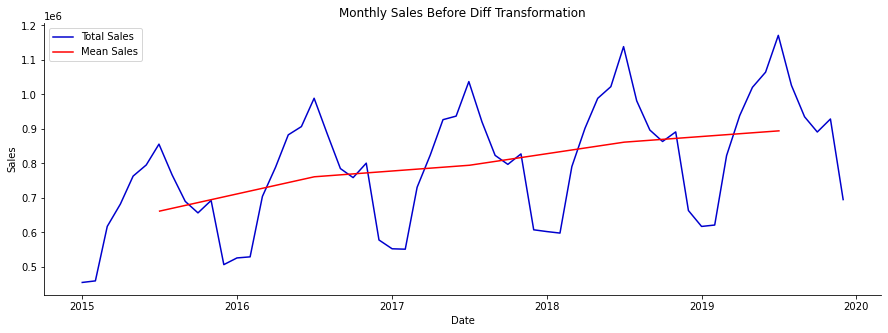

In [11]:
time_plot(month_df, 'date', 'sales', 'Monthly Sales Before Diff Transformation')

C:\Users\mathe\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mathe\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


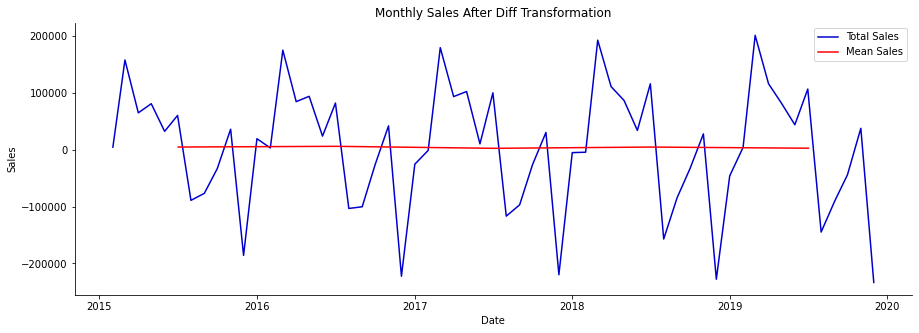

In [12]:
stationary_df = get_diff(month_df)
time_plot(stationary_df, 'date', 'sales_diff', 'Monthly Sales After Diff Transformation')

C:\Users\mathe\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


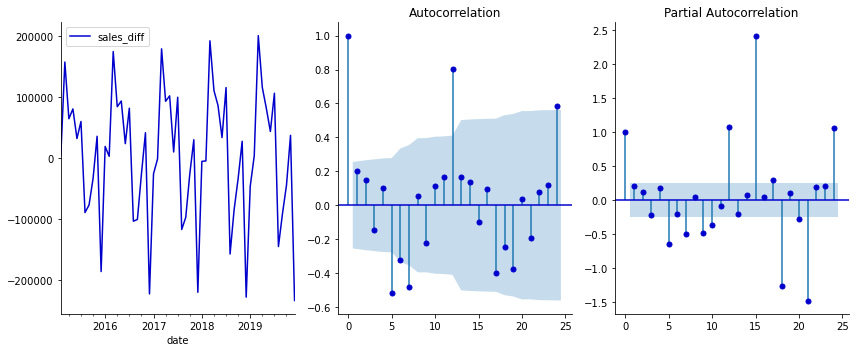

In [13]:
# Observing Lags
dt_data = stationary_df.set_index('date').drop('sales', axis=1)
dt_data.dropna(axis=0)
    
layout = (1, 3)
raw  = plt.subplot2grid(layout, (0, 0))
acf  = plt.subplot2grid(layout, (0, 1))
pacf = plt.subplot2grid(layout, (0, 2))
    
dt_data.plot(ax=raw, figsize=(12, 5), color='mediumblue')
smt.graphics.plot_acf(dt_data, lags=24, ax=acf, color='mediumblue')
smt.graphics.plot_pacf(dt_data, lags=24, ax=pacf, color='mediumblue')
sns.despine()
plt.tight_layout()

In [14]:
# Preparing dataset modeling
def generate_supervised(data):
    supervised_df = data.copy()
    
    #create column for each lag
    for i in range(1,13):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['sales_diff'].shift(i)
    
    #drop null values
    supervised_df = supervised_df.dropna().reset_index(drop=True)
    
    supervised_df.to_csv('data/model_df.csv', index=False)
    
    return supervised_df

def generate_arima_data(data):
    dt_data = data.set_index('date').drop('sales', axis=1)
    dt_data.dropna(axis=0)
    
    dt_data.to_csv('data/arima_df.csv')
    
    return dt_data

In [15]:
model_df = generate_supervised(stationary_df)
model_df

,date,sales,sales_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2016-02-01,529117,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,2016-03-01,704301,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,2016-04-01,788914,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,2016-05-01,882877,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,2016-06-01,906842,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,2016-07-01,989010,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,2016-08-01,885596,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,2016-09-01,785124,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,2016-10-01,758883,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,2016-11-01,800783,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


In [16]:
datetime_df = generate_arima_data(stationary_df)
datetime_df

,sales_diff
date,
2015-02-01,4513.0
2015-03-01,157965.0
2015-04-01,64892.0
2015-05-01,80968.0
2015-06-01,32355.0
2015-07-01,60325.0
2015-08-01,-89161.0
2015-09-01,-76854.0
2015-10-01,-33320.0
